In [1]:
# if you are in the root folder, don't run this line
import os

os.chdir("..")
os.getcwd()

'/home/jibancat/Documents/PYTHON/emu_mpi4py'

In [2]:
from typing import List

import numpy as np
from matplotlib import pyplot as plt
import matplotlib

from matter_multi_fidelity_emu.gpemulator_singlebin import (
    SingleBinGP,
    SingleBinLinearGP,
    SingleBinNonLinearGP,
)
from matter_multi_fidelity_emu.data_loader import PowerSpecs

# set a random number seed to reproducibility
np.random.seed(0)

from itertools import combinations

from trainset_optimize.optmize import TrainSetOptimize

In [3]:
def generate_data(folder: str = "data/50_LR_3_HR/"):
    data = PowerSpecs(folder=folder)
    return data

## Find the HR choices

The following outlines the procedure to select 3 cosmologies for high-fidelity training set
out of low-fidelity latin hypercube (which has 50 cosmologies).

This simple procedure will find the optimal 2 cosmologies first by optizing the low-fidelity only
emulator. This is done by searching all combinations of 2 cosmologies in the LF lating hypercube.

Conditioning on the selected 2 cosmologies, we perform the optimization again to find the 3rd
high-fidelity selection.

In [4]:
# acquire data object, the text files 
data = generate_data()

i_fidelity = 0

X = data.X_train_norm[i_fidelity]
Y = data.Y_train[i_fidelity]

train_opt = TrainSetOptimize(X=X, Y=Y)

# find the optimal two indices first;
# looking for all possible combinations
num_samples, _ = data.X_train[0].shape
num_selected = 2

all_combinations = list(combinations(range(num_samples), num_selected))

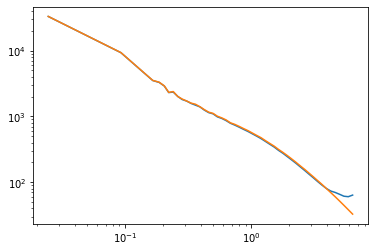

In [5]:
plt.loglog(10**data.kf, 10**data.Y_train[0][9])
plt.loglog(10**data.kf, 10**data.Y_train[1][0])

In [6]:
%%capture
# loop over to get the least loss 2 indices
all_loss = []

for i,selected_index in enumerate(all_combinations):

    # need to convert to boolean array
    ind = np.zeros(num_samples, dtype=np.bool)
    ind[np.array(selected_index)] = True

    loss = train_opt.loss(ind)
    
    print("iteration:", i)

    all_loss.append(loss)

In [7]:
# find the set of indices best minimize the loss
selected_index = np.array(all_combinations[np.argmin(all_loss)])

selected_index

array([19, 37])

## Procedure to find the next optimal index

In [8]:
# find the 3rd HighRes selection
prev_ind = np.zeros(num_samples, dtype=np.bool)
prev_ind[np.array(selected_index)] = True

assert np.sum(prev_ind) == len(selected_index)

In [9]:
%%capture
next_index, all_next_loss = train_opt.optimize(prev_ind,)

In [10]:
# optimal next selection indices
optimal_index = np.append(selected_index, next_index)

optimal_index

array([19, 37, 45])

In [12]:
# the high-fidelity selection is a subset of low-fidelity latin hypercube
# the above cell output means 19th, 37th and 45th cosmologies are the
# choice for the high-fidelity simulation training set.

In [14]:
# cosmologies:
# "omega0", "omegab", "hubble", "scalar_amp", "ns"
data.X_train[0][optimal_index]

array([[2.972e-01, 4.732e-02, 6.650e-01, 2.293e-09, 9.135e-01],
       [3.004e-01, 4.532e-02, 6.710e-01, 2.761e-09, 9.297e-01],
       [2.884e-01, 4.844e-02, 7.090e-01, 2.345e-09, 9.477e-01]])